# Indian Pines HSI Classification

Single-file Python implementation of MATLAB Indian Pines HSI example.

Performs:
- **Preprocess**: Load .mat files, normalize, build balanced training set
- **Train**: 3-layer feed-forward network (single-sample SGD)
- **Postprocess**: Build classification map and save images to result/ folder

Dataset folder (default sibling):
```
Spectral-unmixing-Indian_pines-dataset-with-2D-CNN/
  Indian_pines_corrected.mat
  Indian_pines_gt.mat
```

Outputs (saved into dataset folder):
- preprocessed.npz
- train_results.npz
- result/classified_vs_gt.png
- result/classified.png
- result/ground_truth.png

## Imports and Helper Functions

In [2]:
import os
import numpy as np
from scipy.io import loadmat
from scipy.special import softmax
import matplotlib.pyplot as plt

In [3]:
def load_mat_variable(mat, candidates):
    """Return first matching variable from loaded .mat dict (or first non-dunder entry)."""
    for name in candidates:
        if name in mat:
            return mat[name]
    for k, v in mat.items():
        if not k.startswith('__'):
            return v
    raise KeyError("No suitable variable found in .mat file")

def sigmoid(x):
    """Elementwise sigmoid activation."""
    return 1.0 / (1.0 + np.exp(-x))

## Configuration

Set the dataset directory and training parameters here.

In [5]:
# Configuration
mat_dir = os.path.join(os.getcwd(), "Spectral-unmixing-Indian_pines-dataset-with-2D-CNN")
epochs = 300
alpha = 0.5
rng_seed = 0

## 1. Preprocess

Load Indian Pines .mat files, normalize, and build a balanced training set.

In [6]:
def preprocess(mat_dir, save_npz=True, rng_seed=0):
    """Load Indian Pines .mat files, normalize, build a balanced training set and save preprocessed.npz."""
    im_mat = loadmat(os.path.join(mat_dir, "Indian_pines_corrected.mat"))
    gt_mat = loadmat(os.path.join(mat_dir, "Indian_pines_gt.mat"))
    indian_pines_corrected = load_mat_variable(im_mat, ["indian_pines_corrected", "Indian_pines_corrected"])
    indian_pines_gt = load_mat_variable(gt_mat, ["indian_pines_gt", "Indian_pines_gt"])

    # reshape to (num_pixels, bands)
    h, w, bands = indian_pines_corrected.shape
    im = indian_pines_corrected.reshape(-1, bands)
    gt = indian_pines_gt.reshape(-1)

    # global min-subtract and normalize to [0,1]
    a1 = im - im.min()
    a2 = (a1 - a1.min()) / (a1.max() - a1.min())

    # class labels: make 1-based (MATLAB style)
    gt1 = gt + 1

    # count per-class and pick t = min(N) over classes 1..17
    N = [int((gt1 == k).sum()) for k in range(1, 18)]
    t = min(N)

    idx = []
    rng = np.random.default_rng(seed=rng_seed)
    for kk in range(1, 18):
        f = np.where(gt1 == kk)[0]
        p = rng.choice(f, size=t, replace=False)
        idx.extend(p.tolist())
    idx = np.array(idx, dtype=int)

    # training data
    X1 = a2[idx, :].T            # (bands, 17*t)
    D1 = gt1[idx]               # (17*t,)

    # shuffle training set
    v = rng.permutation(len(D1))
    X = X1[:, v]                # (bands, num_train)
    D2 = D1[v]
    D = np.eye(17)[(D2 - 1).astype(int)].T  # (17, num_train)

    # full pixel set (for inference)
    P = a2.T                    # (bands, num_pixels)

    # reduce features same as MATLAB: take indices 111:140 (1-based) -> 110:140 (0-based, end exclusive)
    X = X[110:140, :]
    P = P[110:140, :]

    if save_npz:
        out = os.path.join(mat_dir, "preprocessed.npz")
        os.makedirs(mat_dir, exist_ok=True)
        np.savez(out, X=X, D=D, P=P, gt1=gt1, indian_pines_gt=indian_pines_gt, shape=(h, w))
        print(f"Saved preprocessed data to: {out}")

    return X, D, P, gt1, indian_pines_gt, (h, w)

In [7]:
print("Preprocessing...")
X, D, P, gt1, indian_pines_gt, shape = preprocess(mat_dir=mat_dir, rng_seed=rng_seed)
print(f"Training data shape: {X.shape}")
print(f"Labels shape: {D.shape}")
print(f"Full pixel data shape: {P.shape}")
print(f"Image shape: {shape}")

Preprocessing...
Saved preprocessed data to: c:\Users\morte\Desktop\enabled\test\Spectral-unmixing-Indian_pines-dataset-with-2D-CNN\preprocessed.npz
Training data shape: (30, 340)
Labels shape: (17, 340)
Full pixel data shape: (30, 21025)
Image shape: (145, 145)


## 2. Train

Train a 3-layer feed-forward network using single-sample SGD.

In [8]:
def train(X, D, P, epochs=300, alpha=0.5, rng_seed=1):
    """Train a 3-layer feed-forward network on the preprocessed data."""
    input_dim = X.shape[0]   # expected 30
    rng = np.random.default_rng(seed=rng_seed)
    W1 = 2 * rng.random((100, input_dim)) - 1     # 100 x input_dim
    W2 = 2 * rng.random((50, 100)) - 1            # 50 x 100
    W3 = 2 * rng.random((17, 50)) - 1             # 17 x 50

    num_samples = X.shape[1]

    for epoch in range(epochs):
        for k2 in range(num_samples):
            x = X[:, k2:k2+1]       # (input_dim,1)
            d = D[:, k2:k2+1]       # (17,1)

            v1 = W1 @ x
            y1 = sigmoid(v1)

            v2 = W2 @ y1
            y2 = sigmoid(v2)

            v = W3 @ y2
            y = softmax(v.flatten())[:, None]

            e = d - y
            delta = e

            e1 = W3.T @ delta
            delta1 = y2 * (1 - y2) * e1

            e2 = W2.T @ delta1
            delta2 = y1 * (1 - y1) * e2

            W3 = W3 + alpha * (delta @ y2.T)
            W2 = W2 + alpha * (delta1 @ y1.T)
            W1 = W1 + alpha * (delta2 @ x.T)
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch + 1}/{epochs} completed")

    # inference over all pixels
    num_pixels = P.shape[1]
    Z = np.zeros((17, num_pixels))
    for k in range(num_pixels):
        x = P[:, k:k+1]
        y1 = sigmoid(W1 @ x)
        y2 = sigmoid(W2 @ y1)
        v = W3 @ y2
        y = softmax(v.flatten())
        Z[:, k] = y

    return W1, W2, W3, Z

In [9]:
print("Training...")
W1, W2, W3, Z = train(X, D, P, epochs=epochs, alpha=alpha, rng_seed=1)
print("Training completed!")

# Save training results
outpath = os.path.join(mat_dir, "train_results.npz")
np.savez(outpath, W1=W1, W2=W2, W3=W3, Z=Z, gt1=gt1, shape=shape)
print(f"Saved training results to: {outpath}")

Training...
Epoch 50/300 completed
Epoch 100/300 completed
Epoch 150/300 completed
Epoch 200/300 completed
Epoch 250/300 completed
Epoch 300/300 completed
Training completed!
Saved training results to: c:\Users\morte\Desktop\enabled\test\Spectral-unmixing-Indian_pines-dataset-with-2D-CNN\train_results.npz


## 3. Postprocess

Build classification map and visualize results.

In [10]:
def postprocess(Z, shape, indian_pines_gt, mat_dir, save_image=True):
    """Build classification map and save result images."""
    C = np.argmax(Z, axis=0) + 1
    classified = C.reshape(shape)

    # create result folder
    result_dir = os.path.join(mat_dir, "result")
    os.makedirs(result_dir, exist_ok=True)

    # draw figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(classified, cmap="tab20")
    axes[0].set_title("Classification Result")
    axes[0].axis("off")
    axes[1].imshow(indian_pines_gt, cmap="tab20")
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    if save_image:
        # save combined figure and individual images to result folder
        combined_path = os.path.join(result_dir, "classified_vs_gt.png")
        fig.savefig(combined_path, bbox_inches="tight", dpi=150)

        classified_path = os.path.join(result_dir, "classified.png")
        gt_path = os.path.join(result_dir, "ground_truth.png")
        plt.imsave(classified_path, classified, cmap="tab20")
        plt.imsave(gt_path, indian_pines_gt, cmap="tab20")

        print(f"Saved images to: {result_dir}")
        print(f" - {combined_path}")
        print(f" - {classified_path}")
        print(f" - {gt_path}")

    plt.show()

    return classified

Postprocessing and visualizing results...
Saved images to: c:\Users\morte\Desktop\enabled\test\Spectral-unmixing-Indian_pines-dataset-with-2D-CNN\result
 - c:\Users\morte\Desktop\enabled\test\Spectral-unmixing-Indian_pines-dataset-with-2D-CNN\result\classified_vs_gt.png
 - c:\Users\morte\Desktop\enabled\test\Spectral-unmixing-Indian_pines-dataset-with-2D-CNN\result\classified.png
 - c:\Users\morte\Desktop\enabled\test\Spectral-unmixing-Indian_pines-dataset-with-2D-CNN\result\ground_truth.png


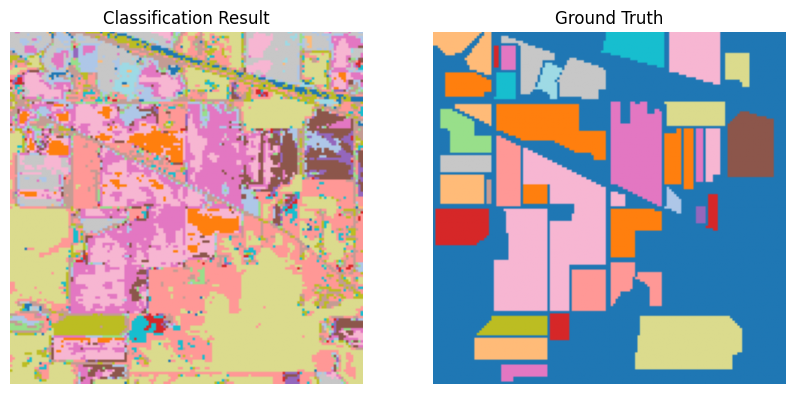

Done!


In [11]:
print("Postprocessing and visualizing results...")
classified = postprocess(Z, shape, indian_pines_gt, mat_dir)
print("Done!")